In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from skimage.transform import resize # from scipy.misc import imresize
from tqdm import tqdm
import nibabel

In [2]:
def read_train_exam(exam_nb):
    image = nibabel.load('../chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('../chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('../chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [3]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [4]:
image_1, mask_1 = read_train_exam(2)


In [5]:
print("before scale {},{},".format(np.unique(mask_1.get_data()),np.unique(image_1.get_data())))

before scale [0 1 2 3 4],[   0    1    2 ... 1474 1501 1503],


In [6]:
print("after scale {},{}".format(np.unique(preprocess(mask_1)),np.unique(preprocess(image_1))))

after scale [0.       0.015625 0.015625 ... 3.984375 3.984375 4.      ],[0.00000000e+00 1.56250000e-02 1.56250000e-02 ... 1.45790625e+03
 1.46843750e+03 1.48428125e+03]


In [9]:
def mask_to_channels(mask,init,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(init,classes)])
    img = np.swapaxes(img,0,-1)#new shape (row,col,class)
    print(img.shape)
    return img

(320, 320, 5)


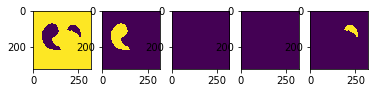

In [10]:
test = mask_1.get_data()[:,:,15]
img = mask_to_channels(test,0,5)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(img[:,:,i])
plt.show()

In [16]:
def create_data_train(train_ids,name, background = 0):
    
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        print(train_id)
        #transform le mask
        if background:
            #create mask for 5 classess
            mask = mask_to_channels(mask,0,5)[0]
        else:
            mask = mask_to_channels(mask,1,5)[0]            
       
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('./dataset/imgs_{}'.format(name), imgs=train_data)
    np.savez_compressed('./dataset/imgs_mask_{}'.format(name), imgs_mask=train_mask)

In [17]:
train_sujets = [1,2,3,5,8]
validation_sujets = [10,13,19]

In [18]:
#dataset training training data
create_data_train(train_sujets,"train_data")

1it [00:00,  3.25it/s]

1
(1, 36, 256, 256, 4)


2it [00:00,  3.11it/s]

2
(1, 26, 256, 256, 4)


3it [00:01,  2.68it/s]

3
(1, 30, 256, 256, 4)
5
(1, 30, 256, 256, 4)


4it [00:01,  2.58it/s]

8
(1, 32, 256, 256, 4)


5it [00:02,  2.28it/s]


Final shape (154, 256, 256, 1),(154, 256, 256, 4)


In [19]:
#dataset training validation data
create_data_train(validation_sujets,"validation_data")

1it [00:00,  3.15it/s]

10
(1, 36, 256, 256, 4)


2it [00:00,  2.92it/s]

13
(1, 30, 256, 256, 4)


3it [00:01,  2.69it/s]

19
(1, 30, 256, 256, 4)
Final shape (96, 256, 256, 1),(96, 256, 256, 4)


### plot images

In [23]:
img = np.load('./dataset/imgs_train_data.npz')['imgs']
img_mask = np.load('./dataset/imgs_mask_train_data.npz')['imgs_mask']

In [44]:
img_mask[:,:,:].shape

(154, 256, 256, 4)

In [25]:
img[:,:,:,0].shape

(154, 256, 256)

In [47]:
#plot random samples from data
def plot_random_images(data,mask):
    index = np.random.choice(range(data.shape[0]),1)[0]
    plt.figure(figsize=(20, 15))
    c = mask.shape[3]
    #image
    plt.subplot(1, c + 1, 1)
    plt.imshow(data[index,:,:,0], cmap='gray', interpolation='nearest')
   
    for i in range(c): 
        plt.subplot(1, c + 1, i+2)
        plt.imshow(mask[index,:,:,i])
    plt.show()

Training data


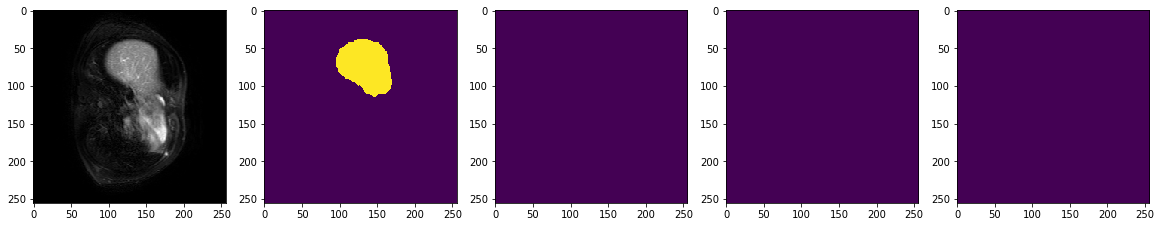

In [48]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask)

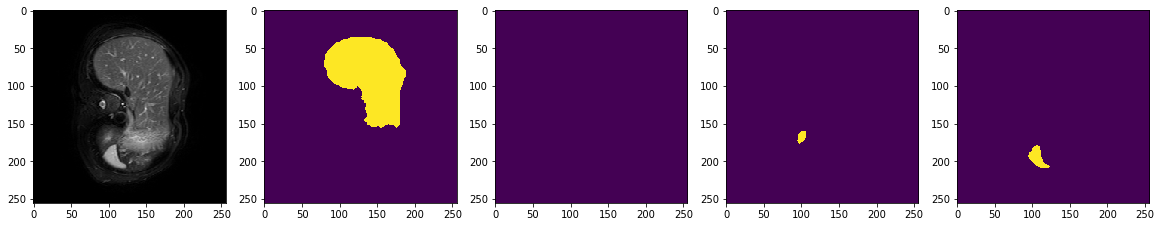

In [51]:
plot_random_images(img,img_mask)

In [52]:
print(np.unique(img))


[0.00000000e+00 1.00974196e-28 1.51461294e-28 ... 1.93000000e+03
 1.93500000e+03 1.97900000e+03]


In [53]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

In [54]:
print(np.unique(imgs_train))

[-0.542792   -0.54276794 -0.5427438  ... 11.364295   11.395143
 11.666599  ]


# MODEL

In [2]:
#version tf1
from keras.models import Model
from keras.layers import Input, concatenate,Conv2D, MaxPooling2D, Conv2DTranspose,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

Using TensorFlow backend.


In [3]:
img_rows = 256
img_cols = 256

In [4]:
smooth = 1.
#batch 32!
def dice_coef_(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):  
    return -dice_coef_(y_true, y_pred)


In [5]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    #conv9 = Conv2D(4, (3,3), activation='relu', padding='same')(conv9)    
    conv10 = Conv2D(4, (1,1), activation='sigmoid')(conv9)    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


# data augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# Load slices
x_val = np.load('./dataset/imgs_validation_data.npz')['imgs'].astype('float32')
y_val =np.load('./dataset/imgs_mask_validation_data.npz')['imgs_mask'].astype('float32')
x_train = np.load('./dataset/imgs_train_data.npz')['imgs'].astype('float32')
y_train = np.load('./dataset/imgs_mask_train_data.npz')['imgs_mask'].astype('float32')

In [8]:
print(x_train.shape,y_train.shape)

(154, 256, 256, 1) (154, 256, 256, 4)


For example, if your original dataset has 10,000 images and your batch size is 32, then a reasonable value for steps_per_epoch when fitting a model on the augmented data might be ceil(10,000/32), or 313 batches.

In [9]:
# create data generator
datagen = ImageDataGenerator(rotation_range=25)
it = datagen.flow(x_train, y_train,batch_size = 32)
# Specify the training configuration (optimizer, loss, metrics)
#checkpointer = ModelCheckpoint(filepath='/weights.hdf5', verbose=1, save_best_only=True)
modelGenerator = get_unet()
#compile
modelGenerator.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef_])
# fit model on the augmented dataset
#250/32 =7,8 (32 batch_size)
steps_per_epoch = len(x_train) // 32
HGenerator = modelGenerator.fit_generator(it, validation_data = (x_val,y_val),
                                          steps_per_epoch= steps_per_epoch, 
                                          epochs=125)

Epoch 1/125
4/4 [==============================] - 11s 3s/step - loss: -0.0155 - acc: 0.0223 - dice_coef_: 0.0155 - val_loss: -0.0213 - val_acc: 0.0493 - val_dice_coef_: 0.0213
Epoch 2/125
4/4 [==============================] - 3s 716ms/step - loss: -0.0330 - acc: 0.1009 - dice_coef_: 0.0330 - val_loss: -0.0274 - val_acc: 0.1966 - val_dice_coef_: 0.0274
Epoch 3/125
4/4 [==============================] - 2s 559ms/step - loss: -0.0392 - acc: 0.2799 - dice_coef_: 0.0392 - val_loss: -0.0278 - val_acc: 0.3515 - val_dice_coef_: 0.0278
Epoch 4/125
4/4 [==============================] - 2s 574ms/step - loss: -0.0347 - acc: 0.3997 - dice_coef_: 0.0347 - val_loss: -0.0275 - val_acc: 0.3942 - val_dice_coef_: 0.0275
Epoch 5/125
4/4 [==============================] - 2s 554ms/step - loss: -0.0420 - acc: 0.4238 - dice_coef_: 0.0420 - val_loss: -0.0280 - val_acc: 0.3728 - val_dice_coef_: 0.0280
Epoch 6/125
4/4 [==============================] - 2s 558ms/step - loss: -0.0393 - acc: 0.3659 - dice_coef_

4/4 [==============================] - 2s 568ms/step - loss: -0.6552 - acc: 0.9684 - dice_coef_: 0.6552 - val_loss: -0.6323 - val_acc: 0.9817 - val_dice_coef_: 0.6323
Epoch 92/125
4/4 [==============================] - 2s 571ms/step - loss: -0.6795 - acc: 0.9676 - dice_coef_: 0.6795 - val_loss: -0.6466 - val_acc: 0.9823 - val_dice_coef_: 0.6466
Epoch 93/125
4/4 [==============================] - 2s 571ms/step - loss: -0.6734 - acc: 0.9696 - dice_coef_: 0.6734 - val_loss: -0.5981 - val_acc: 0.9833 - val_dice_coef_: 0.5981
Epoch 94/125
4/4 [==============================] - 2s 595ms/step - loss: -0.6647 - acc: 0.9677 - dice_coef_: 0.6647 - val_loss: -0.6533 - val_acc: 0.9818 - val_dice_coef_: 0.6533
Epoch 95/125
4/4 [==============================] - 2s 568ms/step - loss: -0.6577 - acc: 0.9699 - dice_coef_: 0.6577 - val_loss: -0.6256 - val_acc: 0.9824 - val_dice_coef_: 0.6256
Epoch 96/125
4/4 [==============================] - 2s 593ms/step - loss: -0.6676 - acc: 0.9686 - dice_coef_: 0.6

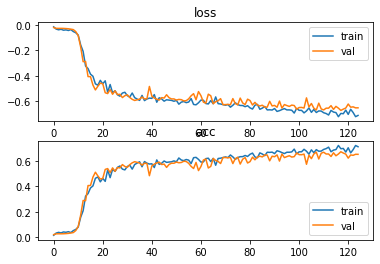

In [10]:
plt.subplot(211)
plt.plot(HGenerator.history['loss'], label='train')
plt.plot(HGenerator.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(HGenerator.history['dice_coef_'], label='train')
plt.plot(HGenerator.history['val_dice_coef_'], label='val')
plt.title('acc')
plt.legend()


https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

In [26]:
id = 110


test = x_train[id,:,:,:]
y_pred = modelGenerator.predict(test.reshape(1,256,256,1))

# results

0.0 1.0
0.0 9.4302864e-05
0.0 0.0002586754
0.0 0.0011562918


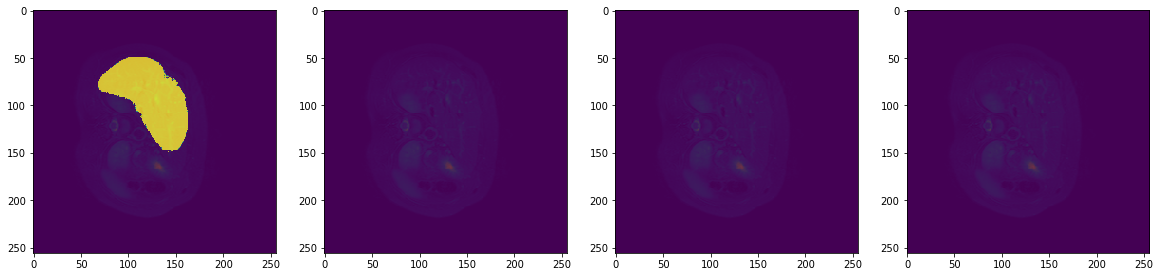

In [27]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.8)
plt.show()

# real

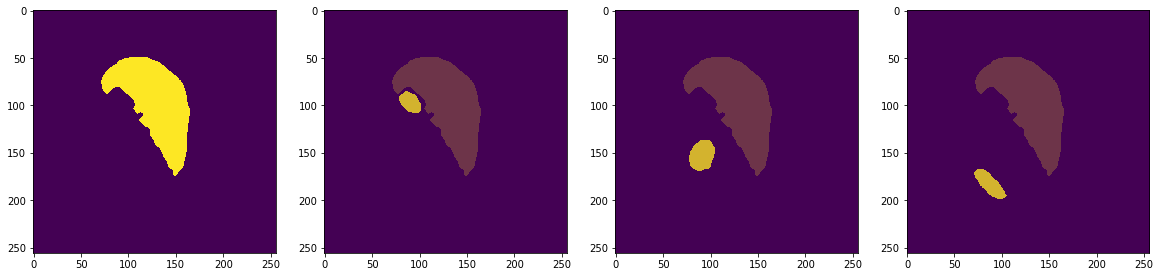

In [28]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = y_train[id,:,:,i]
    plt.imshow(y_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.78)    
plt.show()

# other OUTPUT

In [56]:
def get_unet_ch():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    output_layer = Conv2D(4, (1, 1))(conv9)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=[inputs], outputs=[output_layer])
    
    return model


In [160]:
del mm

In [161]:
from keras.layers import Reshape,Activation
from keras.optimizers import SGD

In [162]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='max', monitor='val_dice_coef_', patience=10, verbose=1)

In [163]:
# create data generator
batch_size = 16

datagen = ImageDataGenerator(rotation_range=25)
it = datagen.flow(x_train, y_train,batch_size = batch_size)
#changee

datagen_v = ImageDataGenerator(rotation_range=25)
it_v = datagen_v.flow(x_val, y_val,batch_size = batch_size)
# Specify the training configuration (optimizer, loss, metrics)
#checkpointer = ModelCheckpoint(filepath='/weights.hdf5', verbose=1, save_best_only=True)
mm = get_unet_ch()
#comple
mm.compile(optimizer = RMSprop(lr = 1e-5), loss=['categorical_crossentropy'], 
              metrics=['accuracy',dice_coef_])
# fit model on the augmented dataset
#250/32 =7,8 (32 batch_size)
steps_per_epoch = len(x_train) // batch_size
steps_per_epoch_val = len(x_val) // batch_size
H = mm.fit_generator(it, validation_data = it_v,
                     validation_steps = steps_per_epoch_val,
                     steps_per_epoch= steps_per_epoch, 
                     epochs=120)

Epoch 1/120
9/9 [==============================] - 6s 620ms/step - loss: 0.3538 - acc: 0.0612 - dice_coef_: 0.0087 - val_loss: 0.2337 - val_acc: 0.1032 - val_dice_coef_: 0.0068
Epoch 2/120
9/9 [==============================] - 3s 279ms/step - loss: 0.2861 - acc: 0.0796 - dice_coef_: 0.0106 - val_loss: 0.1801 - val_acc: 0.0899 - val_dice_coef_: 0.0083
Epoch 3/120
9/9 [==============================] - 3s 280ms/step - loss: 0.2153 - acc: 0.0853 - dice_coef_: 0.0143 - val_loss: 0.1398 - val_acc: 0.0955 - val_dice_coef_: 0.0114
Epoch 4/120
9/9 [==============================] - 3s 287ms/step - loss: 0.1490 - acc: 0.1017 - dice_coef_: 0.0181 - val_loss: 0.1141 - val_acc: 0.1232 - val_dice_coef_: 0.0151
Epoch 5/120
9/9 [==============================] - 2s 270ms/step - loss: 0.1406 - acc: 0.1573 - dice_coef_: 0.0258 - val_loss: 0.1022 - val_acc: 0.2035 - val_dice_coef_: 0.0196
Epoch 6/120
9/9 [==============================] - 3s 288ms/step - loss: 0.1259 - acc: 0.2376 - dice_coef_: 0.0311 

9/9 [==============================] - 3s 283ms/step - loss: 0.0253 - acc: 0.6061 - dice_coef_: 0.0695 - val_loss: 0.0156 - val_acc: 0.5727 - val_dice_coef_: 0.0555
Epoch 48/120
9/9 [==============================] - 3s 300ms/step - loss: 0.0241 - acc: 0.5916 - dice_coef_: 0.0725 - val_loss: 0.0151 - val_acc: 0.5931 - val_dice_coef_: 0.0567
Epoch 49/120
9/9 [==============================] - 3s 291ms/step - loss: 0.0232 - acc: 0.6090 - dice_coef_: 0.0771 - val_loss: 0.0154 - val_acc: 0.5822 - val_dice_coef_: 0.0560
Epoch 50/120
9/9 [==============================] - 3s 291ms/step - loss: 0.0248 - acc: 0.6050 - dice_coef_: 0.0754 - val_loss: 0.0148 - val_acc: 0.5813 - val_dice_coef_: 0.0562
Epoch 51/120
9/9 [==============================] - 3s 292ms/step - loss: 0.0244 - acc: 0.6037 - dice_coef_: 0.0741 - val_loss: 0.0160 - val_acc: 0.5733 - val_dice_coef_: 0.0556
Epoch 52/120
9/9 [==============================] - 3s 290ms/step - loss: 0.0253 - acc: 0.6015 - dice_coef_: 0.0749 - val_l

9/9 [==============================] - 3s 292ms/step - loss: 0.0154 - acc: 0.6159 - dice_coef_: 0.0761 - val_loss: 0.0124 - val_acc: 0.5666 - val_dice_coef_: 0.0579
Epoch 94/120
9/9 [==============================] - 3s 291ms/step - loss: 0.0164 - acc: 0.5965 - dice_coef_: 0.0722 - val_loss: 0.0119 - val_acc: 0.5953 - val_dice_coef_: 0.0587
Epoch 95/120
9/9 [==============================] - 3s 290ms/step - loss: 0.0178 - acc: 0.6082 - dice_coef_: 0.0918 - val_loss: 0.0120 - val_acc: 0.6038 - val_dice_coef_: 0.0595
Epoch 96/120
9/9 [==============================] - 3s 290ms/step - loss: 0.0161 - acc: 0.6041 - dice_coef_: 0.0815 - val_loss: 0.0117 - val_acc: 0.6162 - val_dice_coef_: 0.0595
Epoch 97/120
9/9 [==============================] - 3s 300ms/step - loss: 0.0168 - acc: 0.5907 - dice_coef_: 0.0742 - val_loss: 0.0143 - val_acc: 0.6263 - val_dice_coef_: 0.0596
Epoch 98/120
9/9 [==============================] - 3s 282ms/step - loss: 0.0173 - acc: 0.5932 - dice_coef_: 0.0842 - val_l

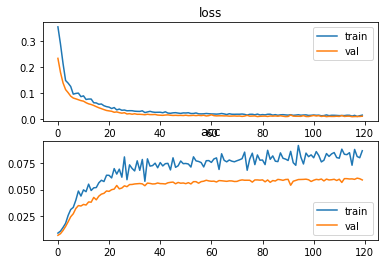

In [164]:
plt.subplot(211)
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(H.history['dice_coef_'], label='train')
plt.plot(H.history['val_dice_coef_'], label='val')
plt.title('acc')
plt.legend()


In [165]:
def get_predict(id,model):
    test = x_train[id,:,:,:]
    return model.predict(test.reshape(1,256,256,1))

In [178]:
id = 69
y_pred = get_predict(id,mm)

In [167]:
np.unique(y_pred)

array([7.3933588e-17, 1.0995872e-16, 1.5225385e-16, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

# results

1.332289e-07 1.0
3.8924647e-10 0.9999602
7.1217115e-13 0.9996331
1.885885e-16 0.99016565


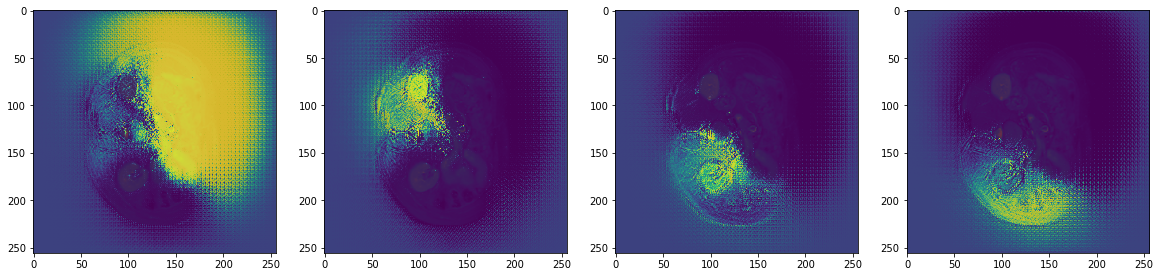

In [179]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=slice_.min(),vmax=slice_.max(), alpha=0.8)
plt.show()

mm.compile(optimizer = RMSprop(lr = 1e-5), loss=['categorical_crossentropy'], 
              metrics=['accuracy',dice_coef_])
# fit model on the augmented dataset
#250/32 =7,8 (32 batch_size)
steps_per_epoch = len(x_train) // 16
H = mm.fit_generator(it, validation_data = (x_val,y_val),
                                          steps_per_epoch= steps_per_epoch, 
                                          epochs=120)

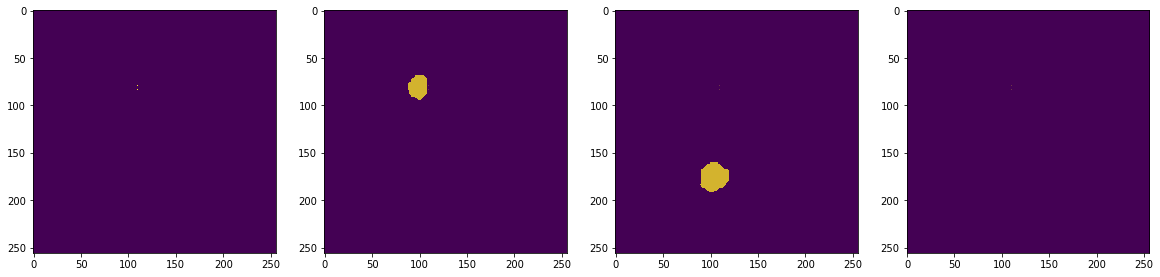

In [180]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = y_train[id,:,:,i]
    plt.imshow(y_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.78)    
plt.show()

5.390363e-13 1.0
3.2095865e-16 0.9999882
1.8785873e-22 0.9999994
1.6487673e-20 0.99999964


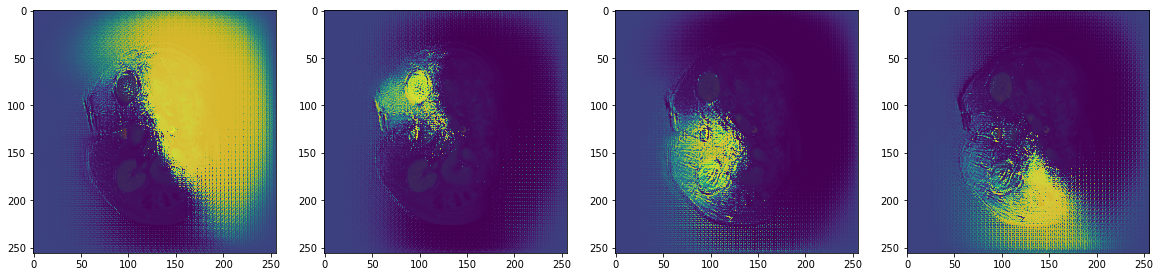

In [50]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.8)
plt.show()

# real

# results

2.1086617e-34 1.0
0.0 1.0
0.0 1.0
0.0 1.0


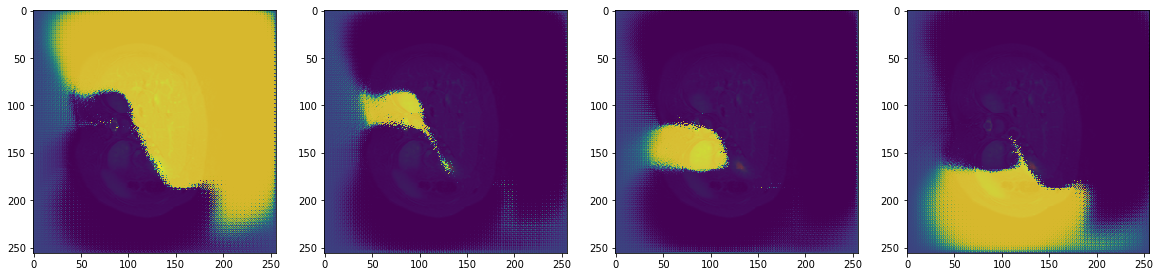

In [19]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.8)
plt.show()